In [203]:
import pandas as pd
import csv
import seaborn as sns
import pytz
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from math import sqrt
from gurobipy import *

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1.0 clean data

In [10]:
def convert_hvac_mode(x):
  if x=='off':
    return 0
  elif x=='cool':
    return 1
  elif x=='heat':
    return -1
  else:
    return 2

def convert_running_equipment(x):
  if x=='fan':
    return 1
  elif x=='compCool1,fan':
    return 2
  elif x=='compCool2,fan':
    return 3
  elif x=='fan,heatPump':
    return -1
  elif x=='auxHeat1,fan':
    return -2
  else:
    return 0

def utc_to_local(x, tz):
    # convert utc datetime to local time, tz='US/Central', 'US/Eastern'
    utc = pytz.timezone('UTC')
    local_tz = pytz.timezone(tz)
    return x.replace(tzinfo=utc).astimezone(tz=local_tz).strftime('%Y-%m-%d %H:%M:%S')

# def utc_to_central(x):
#     utc = pytz.timezone('UTC')
#     central = pytz.timezone('US/Central')
#     return x.replace(tzinfo=utc).astimezone(tz=central).strftime('%Y-%m-%d %H:%M:%S')

# def utc_to_eastern(x):
#     utc = pytz.timezone('UTC')
#     eastern = pytz.timezone('US/Eastern')
#     return x.replace(tzinfo=utc).astimezone(tz=eastern).strftime('%Y-%m-%d %H:%M:%S')

In [145]:
def get_tstat_data(thermostat_id, interval, occpuied_start, occupied_end):
  t1 = df.loc[df['thermostat_id'] == thermostat_id].copy()
  t1.index = pd.to_datetime(t1['timestamp'])
  # round timestamp to '5-min' interval
  t1.index = [x.round(freq=interval) for x in t1.index]
  # remove possible duplicate index
  t1 = t1[~t1.index.duplicated(keep='first')]
  # t1['local_time'] = [utc_to_local(x, 'US/Central') for x in t1.index]
  # t1.set_index('local_time', inplace=True)
  # t1.index = pd.to_datetime(t1.index)
  t1['hour'] = [int(x.strftime('%H')) for x in t1.index]
  t1['weekday'] = [int(x.strftime('%w')) for x in t1.index]
  t1['time'] = [x.strftime('%H:%M') for x in t1.index]

  # add occupied, hvac mode and running equipment mode
  t1['occupied'] = [1 if (x >= occpuied_start) and (
      x <= occupied_end) else 0 for x in t1.time]
  t1.loc[t1['weekday'].isin([0, 6]), ['occupied']] = 0
  t1['hvac_mode'] = [convert_hvac_mode(x) for x in t1.hvac_mode]
  t1['running_equipment'] = [
      convert_running_equipment(x) for x in t1.running_equipment]

  t1['outside_temperature_c'] = (t1['outside_temperature_f']-32)/1.8
  t1['temperature_c'] = (t1['temperature_f']-32)/1.8
  t1['tstat_heat'] = 21  # add reference heating setpoint
  t1['tstat_heat_mesa'] = (t1['heat_setpoint_f']-32)/1.8
  t1['tstat_cool'] = 21  # add reference cooling setpoint
  t1['tstat_cool_mesa'] = (t1['cool_setpoint_f']-32)/1.8

  return t1


In [130]:
def merge_ecobee_solar(ecobee, solar, interval):
    solar_sampled = solar.resample(interval)
    solar_interpolated = solar_sampled.interpolate(method='spline', order=2)
    solar_interpolated.index = pd.to_datetime(solar_interpolated.index)
    df = pd.concat([ecobee, solar_interpolated])
    df = df.fillna(0)
    return df

In [146]:
tstat_id = 521738394095
df = pd.read_csv('data/300SW/300 SW 1st Ave_{}.csv'.format(tstat_id))
t1 = get_tstat_data(tstat_id, '5T', '08:00', '18:00')

In [137]:
wea = pd.read_csv('data/300SW/300SW_weather_solar.csv', index_col=[0], parse_dates=True)
solar_sampled = wea[['DNI','DHI']].resample('5T')
solar_interpolated = solar_sampled.interpolate(method='spline', order=2)
solar_interpolated.index = pd.to_datetime(solar_interpolated.index)

solar_interpolated.head()

,DNI,DHI
datetime,,
2021-11-30 00:00:00,0.000000,0.000000
2021-11-30 00:05:00,0.000924,0.000380
2021-11-30 00:10:00,0.001709,0.000630
2021-11-30 00:15:00,0.002330,0.000818
2021-11-30 00:20:00,0.002788,0.000944


In [152]:
t1_wea = t1.join(solar_interpolated, how='inner')

<AxesSubplot:>

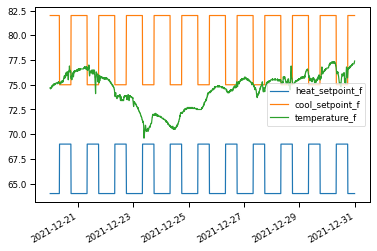

In [155]:
t1_wea.loc['2021-12-20':'2021-12-30',['heat_setpoint_f', 'cool_setpoint_f','temperature_f']].plot()

# 2.0 Linear model for packaged AC unit

## model formulation, define model parameters from building

Tr: room temperature
Tm: temperature of the building's lumped thermal mass
Cr: thermal capacitance of the room
Cm: thermal capacitance of the thermal mass
Ta: ambient temperature
Rra: thermal resistance between the room and the ambient
Rrm: thermal resistance between the room and the thermal mass
G: solar irradiance
Sa: solar irradiance absorption factor
Ig: internal heat gain


## (1) 1 state and 1 step model prediction

In [177]:
# prepare the modeling training dataset
# Tr, m, Ta, G, and I
def prepare_data(df, start_date, end_date, dropnan=True):
    data = df[start_date:end_date][['temperature_c', 'running_equipment',
                                    'outside_temperature_c', 'DNI', 'DHI', 'occupied']].copy()
    if dropnan:
        data.dropna(inplace=True)
    return data.values
# Tr = training_data['temperature_c'].values
# Ta = training_data['outside_temperature_c'].values
# Gn = training_data['DNI'].values
# Gh = training_data['DHI'].values
# AC = training_data['running_equipment'].values
# Ig = training_data['occupied'].values


In [190]:
# model
def model_one_state(data):
    # create model
    m = Model("AirConditioner")

    # add model parameters
    N = len(data)
    m_param = {}
    for i in range(6):
        m_param[i] = m.addVar(lb=0, name='m_param_%s' % (i))

    Tr_hat = {}
    for k in range(N):
        Tr_hat[k] = m.addVar(name='Tr_hat_%s' % (k))

    for k in range(N-1):
        m.addConstr(Tr_hat[k+1] == (m_param[0])*data[k][0] + (-m_param[1])*data[k][1] +
                    m_param[2]*data[k][2] + m_param[3]*data[k][3] + m_param[4]*data[k][4] + m_param[5]*data[k][5], 'c0_%s' % (k))

    # Set objective:
    obj = quicksum((Tr_hat[k] - data[k][0])*(Tr_hat[k] - data[k][0]) for k in range(N))
    m.setObjective(obj, GRB.MINIMIZE)

    # solve the opt
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m
    else:
        print('Infeasible')

def get_model_param(m):
    m_param_vars = [var for var in m.getVars() if "m_param" in var.VarName]
    m_param_values = m.getAttr('x', m_param_vars)
    return m_param_values


In [215]:
def get_model_param(m):
    m_param_vars = [var for var in m.getVars() if "m_param" in var.VarName]
    m_param_values = m.getAttr('x', m_param_vars)
    return m_param_values

def get_y_predicted(m):
    # get the list of model variable names
    Tr_hat = [var for var in m.getVars() if "Tr_hat" in var.VarName]
    estimated = m.getAttr('x', Tr_hat)
    return estimated

# Calculate model metrics
def calc_model_metrics(y, y_predicted):
    # convert to array like
    y = np.array(y)
    y_predicted = np.array(y_predicted)
    y = y.reshape(len(y),1)
    y_predicted = y_predicted.reshape(len(y_predicted),1)
    # calculate model metrics
    MAE = "{:.3f}".format(mean_absolute_error(y, y_predicted))
    nMAE = "{:.3f}".format(mean_absolute_error(y, y_predicted)/np.mean(y))
    MBE = "{:.3f}".format(np.mean(y_predicted-y))
    nMBE = "{:.3f}".format(np.sum(y_predicted-y)/(len(y)-1)/np.mean(y))
    RSME = "{:.3f}".format(sqrt(mean_squared_error(y, y_predicted)))
    nRSME = "{:.3f}".format(
        sqrt(mean_squared_error(y, y_predicted))/np.mean(y))
    R2 = "{:.3f}".format(r2_score(y, y_predicted))
    return [MAE, nMAE, MBE, nMBE, RSME, nRSME, R2]

In [216]:
test = prepare_data(t1_wea, '2021-12-20', '2021-12-30', dropnan=True)
# opt linear model
m = model_one_state(test)

# get predicted room temperature Tr_hat
y_predicted = get_y_predicted(m)
y = [row[0] for row in test]

# calc model errors
err = calc_model_metrics(y, y_predicted)


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3157 rows, 3164 columns and 17225 nonzeros
Model fingerprint: 0xd2850a10
Model has 3158 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-07, 1e+03]
  Objective range  [4e+01, 5e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.03s
Presolved: 3157 rows, 3163 columns, 17225 nonzeros
Presolved model has 3157 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 1.407e+04
 Factor NZ  : 1.725e+04 (roughly 3 MB of memory)
 Factor Ops : 9.671e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.16385377e+08 -7.87482679e+08  3

/Users/ryin/new_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


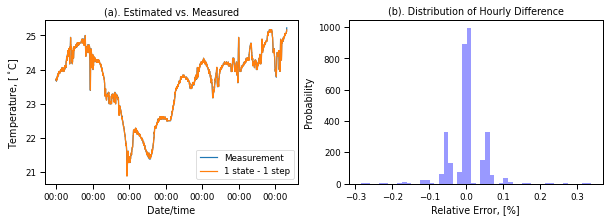

In [218]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axes[0].plot(range(len(y)), y, label='Measurement')
axes[0].plot(range(len(y)), y_predicted, label='1 state - 1 step')
sns.distplot((np.array(y_predicted) - np.array(y)), kde=False, color="b", ax=axes[1])
axes[0].set_xlabel('Date/time')
axes[0].set_ylabel('Temperature, [$^\circ$C]')
axes[0].set_title('(a). Estimated vs. Measured')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1, interval=1, tz=None))
axes[1].set_xlabel('Relative Error, [%]')
axes[1].set_ylabel('Probability')
axes[1].set_title('(b). Distribution of Hourly Difference')

axes[0].legend()

fig.savefig('figures/validate-error1.png', dpi=300, format='png',bbox_inches='tight')